## Fine-Tuning the YOLO Model

In [ ]:
# This was grabbed straight from the Dataset docs
from ultralytics import YOLO

# Load a pretrained segmentation model like YOLO26n-seg
model = YOLO("yolo26n-seg.pt")

# Train the model on the Carparts Segmentation dataset
results = model.train(data="carparts-seg.yaml", epochs=150, imgsz=640)

# After training, you can validate the model's performance on the validation set
results = model.val()

## Loading a Pretrained Model

In [1]:
from ultralytics import YOLO

model = YOLO("runs/segment/train/weights/best.pt")
confidence = 0.4 # obtained by maximizing the F1 score on the F1 v confidence threshold graph from YOLO validation/training


image 1/1 /Users/lakshyajain/Documents/College/Classes/year 2/spring/Artificial Intelligence/eng-ai-agents/assignments/assignment-2/data/extracted/frame_0282.jpg: 384x640 1 back_bumper, 1 back_glass, 1 tailgate, 1 wheel, 63.1ms
Speed: 2.7ms preprocess, 63.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
4


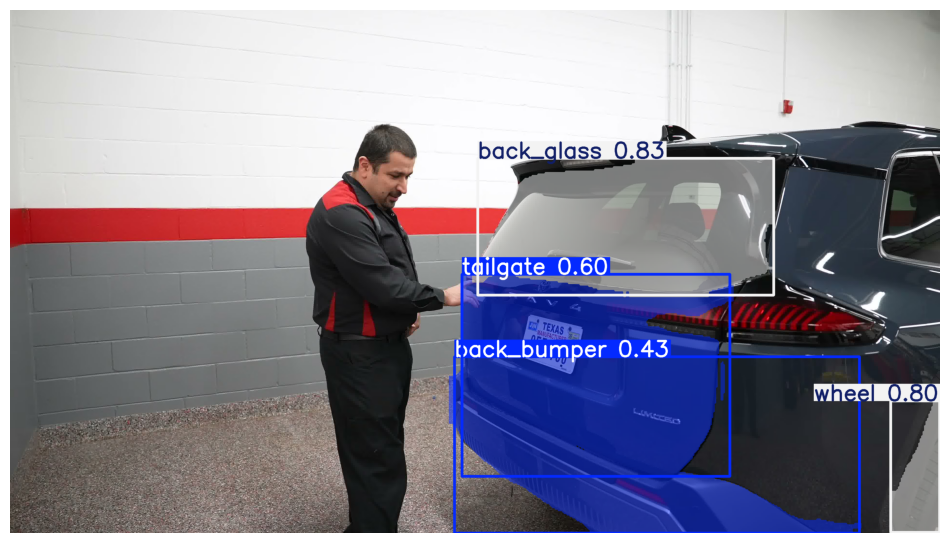

In [2]:
from matplotlib import pyplot as plt

frame_path = "data/extracted/frame_0282.jpg"

results = model.predict(frame_path, conf=confidence)

num_preds = len(results[0].boxes)
print(num_preds)

res_plotted = results[0].plot()
res_rgb = res_plotted[:, :, ::-1] 

plt.figure(figsize=(12, 8))
plt.imshow(res_rgb)
plt.axis('off')  # Hide pixel coordinates
plt.show()

## Generate parquet file for labels of each frame

In [3]:
from os.path import join
import glob
import pandas as pd


from tqdm import tqdm

List/Dictionaries for converting from number to label and vice versa

In [4]:
label_num = {
  "back_bumper": 0,
  "back_door": 1,
  "back_glass": 2,
  "back_left_door": 3,
  "back_left_light": 4,
  "back_light": 5,
  "back_right_door": 6,
  "back_right_light": 7,
  "front_bumper": 8,
  "front_door": 9,
  "front_glass": 10,
  "front_left_door": 11,
  "front_left_light": 12,
  "front_light": 13,
  "front_right_door": 14,
  "front_right_light": 15,
  "hood": 16,
  "left_mirror": 17,
  "object": 18,
  "right_mirror": 19,
  "tailgate": 20,
  "trunk": 21,
  "wheel": 22
}

labels = [
  "back_bumper", 
  "back_door", 
  "back_glass", 
  "back_left_door",
  "back_left_light",
  "back_light", 
  "back_right_door", 
  "back_right_light", 
  "front_bumper", 
  "front_door",
  "front_glass",
  "front_left_door", 
  "front_left_light",
  "front_light", 
  "front_right_door",
  "front_right_light", 
  "hood", 
  "left_mirror", 
  "object", 
  "right_mirror", 
  "tailgate", 
  "trunk",
  "wheel"
]

In [5]:
label = labels[16]

print(label, label_num[label])

hood 16


Grab all the frames in the folder (prextracted via ffmpeg)

In [6]:
frame_dir = "data/extracted/"
frame_paths = sorted(glob.glob(join(frame_dir, "*.jpg")))
print(len(frame_paths))

365


In [7]:
def get_timestamp_sec(img_idx, start_idx = 1119, fps = 1):

    return start_idx + (img_idx/fps)

In [40]:
def get_img_from_stamp(seconds, start_idx = 1119, fps=1):
    return (seconds - start_idx) * fps
    
# def get_timestamp_sec(img_idx, start_idx = 1119, fps = 1):
#   return start_idx + (img_idx/fps)

In [8]:
batch_size = 16

video_id = "YcvECxtXoxQ"

video_ids = []
timestamp_sec = []
class_label = []
bounding_boxes = []
confidence_score = []

for i in tqdm(range(0, len(frame_paths), batch_size), desc="Processing Frames"):
    batch = frame_paths[i : i+batch_size]
    results = model.predict(batch, conf=confidence)

    for j in range(len(results)):
        result = results[j]
        num_preds = len(result.boxes)

        video_id_list = ["YcvECxtXoxQ"] * num_preds
        time_list = [get_timestamp_sec((i + j))] * num_preds
        class_ids_list = [result.names[k] for k in result.boxes.cls.int().tolist()]
        box_list = [tuple(k.tolist()) for k in result.boxes.xyxy]
        conf_list = result.boxes.conf.tolist()

        video_ids.extend(video_id_list)
        timestamp_sec.extend(time_list)
        class_label.extend(class_ids_list)
        bounding_boxes.extend(box_list)
        confidence_score.extend(conf_list)

# print(video_ids)
# print(timestamp_sec)
# print(class_label)
# print(bounding_boxes)
# print(confidence_score)

data = {
    "video_id": video_ids,
    "timestamp_sec": timestamp_sec,
    "class_label": class_label,
    "bounding_box": bounding_boxes,
    "confidence_score": confidence_score
}

df = pd.DataFrame(data)

df.to_parquet('car_detections.parquet', engine='pyarrow', compression='snappy')

print("File saved successfully!")


Processing Frames:   0%|          | 0/23 [00:00<?, ?it/s]


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 1 left_mirror, 127.2ms
1: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 left_mirror, 127.2ms
2: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 1 left_mirror, 1 wheel, 127.2ms
3: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 1 wheel, 127.2ms
4: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 127.2ms
5: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 right_mirror, 127.2ms
6: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 1 left_mirror, 127.2ms
7: 384x640 1 back_glass, 1 front_bumper, 1 front_glass, 1 front_left_light, 127.2ms
8: 384x640 1 back_glass, 1 front_bumper, 1 front_left_light, 127.2ms
9: 384x640 1 back_glass, 1 front_bumper, 127.2ms
10: 384x640 1 back_glass, 127.2ms
11: 384x640 1 back_glass, 1 front_bumper, 1 wheel, 127.2ms
12: 384x640 1

Processing Frames:   4%|▍         | 1/23 [00:03<01:12,  3.29s/it]


0: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 126.2ms
1: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 126.2ms
2: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 wheel, 126.2ms
3: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 wheel, 126.2ms
4: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 126.2ms
5: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 wheel, 126.2ms
6: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 right_mirror, 126.2ms
7: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 right_mirror, 126.2ms
8: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 126.2ms
9: 384x640 1 back_glass, 1 front_bumper, 1 front_left_light, 2 left_mirrors, 126.2ms
10: 384x640 1 back_glass, 1 wheel, 126.2ms
11: 384x640 (no detections), 126.2ms
12: 384x640 1 back_glass, 1 trunk, 126.2ms
13: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 f

Processing Frames:   9%|▊         | 2/23 [00:06<01:06,  3.16s/it]


0: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 right_mirror, 129.7ms
1: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 2 left_mirrors, 129.7ms
2: 384x640 1 back_glass, 1 front_bumper, 1 front_glass, 2 front_left_lights, 2 hoods, 2 left_mirrors, 129.7ms
3: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 left_mirror, 1 right_mirror, 129.7ms
4: 384x640 1 back_glass, 1 front_bumper, 1 front_glass, 3 front_left_lights, 1 left_mirror, 129.7ms
5: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 1 hood, 2 left_mirrors, 1 right_mirror, 129.7ms
6: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 2 right_mirrors, 129.7ms
7: 384x640 1 front_bumper, 1 front_glass, 2 hoods, 1 left_mirror, 129.7ms
8: 384x640 1 back_glass, 2 left_mirrors, 129.7ms
9: 384x640 1 hood, 129.7ms
10: 384x640 (no detections), 129.7ms
11: 384x640 1 back_left_light, 1 back_right_light, 1 wheel, 129.7ms
12: 384x640 1 front_bumper, 1 w

Processing Frames:  13%|█▎        | 3/23 [00:09<01:02,  3.15s/it]


0: 384x640 1 back_glass, 1 front_bumper, 1 left_mirror, 150.0ms
1: 384x640 1 front_bumper, 1 front_glass, 1 left_mirror, 150.0ms
2: 384x640 1 front_bumper, 1 front_glass, 1 left_mirror, 150.0ms
3: 384x640 1 front_bumper, 1 front_glass, 2 left_mirrors, 150.0ms
4: 384x640 2 front_bumpers, 1 front_glass, 1 front_left_light, 2 hoods, 2 left_mirrors, 150.0ms
5: 384x640 2 front_bumpers, 1 front_glass, 2 hoods, 2 left_mirrors, 150.0ms
6: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 left_mirror, 150.0ms
7: 384x640 1 front_bumper, 1 front_glass, 2 hoods, 1 left_mirror, 150.0ms
8: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 1 hood, 1 left_mirror, 150.0ms
9: 384x640 2 front_bumpers, 1 front_glass, 1 hood, 2 left_mirrors, 150.0ms
10: 384x640 2 front_bumpers, 1 front_glass, 1 hood, 1 left_mirror, 150.0ms
11: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 2 hoods, 2 left_mirrors, 150.0ms
12: 384x640 2 front_bumpers, 1 front_left_light, 2 hoods, 2

Processing Frames:  17%|█▋        | 4/23 [00:12<01:01,  3.26s/it]


0: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 left_mirrors, 138.5ms
1: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 138.5ms
2: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 1 hood, 2 left_mirrors, 138.5ms
3: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 138.5ms
4: 384x640 2 front_bumpers, 1 front_glass, 1 front_left_light, 1 hood, 3 left_mirrors, 138.5ms
5: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 left_mirrors, 138.5ms
6: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 2 left_mirrors, 138.5ms
7: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 left_mirrors, 138.5ms
8: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 138.5ms
9: 384x640 1 front_bumper, 1 front_glass, 2 left_mirrors, 138.5ms
10: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 138.5ms
11: 384x640 1 front_bumper, 1 front_glass, 1 hood, 3 left_mirrors, 138.5ms
12: 384x640 1 front_glass, 1 front_left_light, 1 hood,

Processing Frames:  22%|██▏       | 5/23 [00:16<00:58,  3.27s/it]


0: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 left_mirrors, 1 wheel, 128.1ms
1: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 2 left_mirrors, 128.1ms
2: 384x640 2 front_bumpers, 1 front_glass, 1 hood, 2 left_mirrors, 128.1ms
3: 384x640 1 front_bumper, 1 hood, 2 left_mirrors, 128.1ms
4: 384x640 1 back_glass, 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 128.1ms
5: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 4 left_mirrors, 128.1ms
6: 384x640 2 front_bumpers, 1 front_glass, 1 front_left_light, 1 hood, 1 left_mirror, 128.1ms
7: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 128.1ms
8: 384x640 1 front_bumper, 1 front_glass, 2 front_left_lights, 1 hood, 1 left_mirror, 1 wheel, 128.1ms
9: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 1 left_mirror, 1 wheel, 128.1ms
10: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 1 left_mirror, 128.1ms
11:

Processing Frames:  26%|██▌       | 6/23 [00:19<00:54,  3.23s/it]


0: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 1 left_mirror, 1 wheel, 128.8ms
1: 384x640 1 front_glass, 1 hood, 1 left_mirror, 128.8ms
2: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 right_mirror, 128.8ms
3: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 128.8ms
4: 384x640 1 front_glass, 1 left_mirror, 128.8ms
5: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 1 right_mirror, 128.8ms
6: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 left_mirrors, 128.8ms
7: 384x640 1 back_glass, 1 front_bumper, 1 front_glass, 1 hood, 1 left_mirror, 128.8ms
8: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 2 hoods, 1 left_mirror, 128.8ms
9: 384x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 hood, 2 left_mirrors, 1 wheel, 128.8ms
10: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 hood, 2 left_mirrors, 128.8ms
11: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 

Processing Frames:  30%|███       | 7/23 [00:22<00:50,  3.18s/it]


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 2 wheels, 139.8ms
1: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 hood, 2 wheels, 139.8ms
2: 384x640 1 front_bumper, 1 front_glass, 1 front_left_door, 2 wheels, 139.8ms
3: 384x640 1 back_left_door, 1 front_bumper, 1 front_left_door, 1 wheel, 139.8ms
4: 384x640 (no detections), 139.8ms
5: 384x640 (no detections), 139.8ms
6: 384x640 (no detections), 139.8ms
7: 384x640 (no detections), 139.8ms
8: 384x640 1 back_left_door, 1 front_glass, 1 front_right_door, 2 wheels, 139.8ms
9: 384x640 1 back_left_door, 1 front_glass, 1 front_left_door, 1 hood, 139.8ms
10: 384x640 1 back_left_door, 2 front_glasss, 1 front_left_door, 1 hood, 1 left_mirror, 1 wheel, 139.8ms
11: 384x640 1 front_glass, 1 front_left_door, 1 hood, 1 left_mirror, 139.8ms
12: 384x640 1 front_glass, 1 front_left_door, 1 front_left_light, 1 hood, 1 left_mirror, 1 wheel, 139.8ms
13: 384x640 1 fr

Processing Frames:  35%|███▍      | 8/23 [00:25<00:48,  3.20s/it]


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 hood, 1 left_mirror, 1 wheel, 133.8ms
1: 384x640 1 front_bumper, 1 front_glass, 1 hood, 2 wheels, 133.8ms
2: 384x640 1 front_bumper, 1 front_glass, 1 hood, 1 wheel, 133.8ms
3: 384x640 1 front_glass, 1 hood, 133.8ms
4: 384x640 1 front_glass, 1 hood, 133.8ms
5: 384x640 (no detections), 133.8ms
6: 384x640 2 front_glasss, 133.8ms
7: 384x640 (no detections), 133.8ms
8: 384x640 1 back_glass, 1 front_glass, 133.8ms
9: 384x640 (no detections), 133.8ms
10: 384x640 1 back_bumper, 1 wheel, 133.8ms
11: 384x640 1 hood, 133.8ms
12: 384x640 (no detections), 133.8ms
13: 384x640 1 back_bumper, 1 back_glass, 1 front_glass, 1 front_left_door, 133.8ms
14: 384x640 1 back_glass, 1 back_left_door, 1 front_left_door, 1 wheel, 133.8ms
15: 384x640 1 back_left_door, 1 front_glass, 1 front_left_door, 1 wheel, 133.8ms
Speed: 2.1ms preprocess, 133.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  39%|███▉      | 9/23 [00:28<00:44,  3.18s/it]


0: 384x640 1 back_glass, 1 back_left_door, 1 front_left_door, 2 wheels, 125.6ms
1: 384x640 1 back_left_door, 1 front_left_door, 1 wheel, 125.6ms
2: 384x640 1 back_glass, 1 back_left_door, 1 front_glass, 1 front_left_door, 2 wheels, 125.6ms
3: 384x640 1 back_bumper, 2 back_left_doors, 1 front_glass, 1 front_left_door, 1 wheel, 125.6ms
4: 384x640 2 back_left_doors, 1 front_glass, 1 front_left_door, 1 wheel, 125.6ms
5: 384x640 1 back_left_door, 1 front_glass, 1 front_left_door, 1 wheel, 125.6ms
6: 384x640 1 back_bumper, 1 back_left_door, 1 front_glass, 1 front_left_door, 2 wheels, 125.6ms
7: 384x640 1 back_bumper, 1 back_left_door, 1 back_left_light, 1 front_glass, 1 front_left_door, 2 wheels, 125.6ms
8: 384x640 1 back_bumper, 1 back_left_door, 1 front_glass, 1 front_left_door, 2 wheels, 125.6ms
9: 384x640 1 back_bumper, 1 back_left_door, 1 front_glass, 1 front_left_door, 1 wheel, 125.6ms
10: 384x640 1 back_bumper, 1 back_left_door, 1 front_glass, 1 front_left_door, 1 wheel, 125.6ms
11: 

Processing Frames:  43%|████▎     | 10/23 [00:31<00:40,  3.13s/it]


0: 384x640 1 back_left_door, 1 front_glass, 2 wheels, 124.4ms
1: 384x640 1 back_left_door, 1 wheel, 124.4ms
2: 384x640 1 back_left_light, 2 wheels, 124.4ms
3: 384x640 1 front_bumper, 2 wheels, 124.4ms
4: 384x640 1 front_glass, 1 wheel, 124.4ms
5: 384x640 1 back_left_door, 1 front_glass, 124.4ms
6: 384x640 1 back_left_door, 1 front_glass, 1 trunk, 1 wheel, 124.4ms
7: 384x640 1 back_glass, 1 front_glass, 1 wheel, 124.4ms
8: 384x640 1 front_glass, 2 wheels, 124.4ms
9: 384x640 1 back_bumper, 1 hood, 124.4ms
10: 384x640 1 back_bumper, 124.4ms
11: 384x640 1 hood, 1 trunk, 124.4ms
12: 384x640 1 front_glass, 124.4ms
13: 384x640 1 front_glass, 124.4ms
14: 384x640 1 front_glass, 1 tailgate, 124.4ms
15: 384x640 1 front_glass, 1 tailgate, 1 trunk, 124.4ms
Speed: 2.0ms preprocess, 124.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  48%|████▊     | 11/23 [00:34<00:37,  3.09s/it]


0: 384x640 1 front_glass, 141.3ms
1: 384x640 1 front_glass, 141.3ms
2: 384x640 1 trunk, 141.3ms
3: 384x640 1 wheel, 141.3ms
4: 384x640 1 back_glass, 141.3ms
5: 384x640 (no detections), 141.3ms
6: 384x640 (no detections), 141.3ms
7: 384x640 (no detections), 141.3ms
8: 384x640 1 back_right_door, 141.3ms
9: 384x640 (no detections), 141.3ms
10: 384x640 1 wheel, 141.3ms
11: 384x640 1 back_left_door, 1 front_left_door, 1 wheel, 141.3ms
12: 384x640 1 back_left_door, 1 front_left_door, 1 wheel, 141.3ms
13: 384x640 1 back_left_door, 1 wheel, 141.3ms
14: 384x640 (no detections), 141.3ms
15: 384x640 (no detections), 141.3ms
Speed: 2.1ms preprocess, 141.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  52%|█████▏    | 12/23 [00:38<00:34,  3.13s/it]


0: 384x640 1 wheel, 136.6ms
1: 384x640 1 back_left_door, 1 wheel, 136.6ms
2: 384x640 1 wheel, 136.6ms
3: 384x640 1 wheel, 136.6ms
4: 384x640 1 wheel, 136.6ms
5: 384x640 2 back_left_doors, 1 wheel, 136.6ms
6: 384x640 1 wheel, 136.6ms
7: 384x640 1 trunk, 136.6ms
8: 384x640 1 trunk, 136.6ms
9: 384x640 1 wheel, 136.6ms
10: 384x640 (no detections), 136.6ms
11: 384x640 1 trunk, 2 wheels, 136.6ms
12: 384x640 1 wheel, 136.6ms
13: 384x640 1 tailgate, 1 trunk, 1 wheel, 136.6ms
14: 384x640 1 trunk, 1 wheel, 136.6ms
15: 384x640 1 trunk, 2 wheels, 136.6ms
Speed: 2.6ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  57%|█████▋    | 13/23 [00:41<00:31,  3.17s/it]


0: 384x640 1 back_bumper, 1 wheel, 148.9ms
1: 384x640 1 wheel, 148.9ms
2: 384x640 2 back_left_doors, 1 front_left_door, 1 wheel, 148.9ms
3: 384x640 2 back_left_doors, 1 back_left_light, 1 front_left_door, 1 wheel, 148.9ms
4: 384x640 2 back_left_doors, 1 back_left_light, 1 back_right_light, 1 front_left_door, 1 wheel, 148.9ms
5: 384x640 1 back_left_door, 1 wheel, 148.9ms
6: 384x640 1 back_left_door, 148.9ms
7: 384x640 1 back_left_door, 1 front_left_door, 1 wheel, 148.9ms
8: 384x640 1 back_left_door, 148.9ms
9: 384x640 1 back_left_light, 148.9ms
10: 384x640 1 back_left_door, 1 front_left_door, 1 left_mirror, 1 wheel, 148.9ms
11: 384x640 2 back_left_doors, 148.9ms
12: 384x640 1 back_left_door, 1 back_left_light, 1 wheel, 148.9ms
13: 384x640 1 back_glass, 1 back_left_door, 1 back_left_light, 148.9ms
14: 384x640 1 back_left_door, 148.9ms
15: 384x640 1 back_glass, 1 back_left_door, 1 wheel, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 

Processing Frames:  61%|██████    | 14/23 [00:44<00:29,  3.26s/it]


0: 384x640 1 back_left_door, 1 wheel, 127.9ms
1: 384x640 1 back_left_door, 127.9ms
2: 384x640 1 back_glass, 1 back_left_door, 1 wheel, 127.9ms
3: 384x640 2 back_glasss, 1 back_left_door, 1 back_left_light, 127.9ms
4: 384x640 1 back_glass, 1 back_left_door, 1 back_left_light, 1 wheel, 127.9ms
5: 384x640 1 back_glass, 1 back_left_door, 1 back_left_light, 1 wheel, 127.9ms
6: 384x640 1 back_left_door, 1 front_left_door, 1 wheel, 127.9ms
7: 384x640 2 back_left_doors, 1 wheel, 127.9ms
8: 384x640 2 back_left_doors, 1 wheel, 127.9ms
9: 384x640 1 back_left_light, 127.9ms
10: 384x640 1 back_left_light, 127.9ms
11: 384x640 1 back_left_light, 127.9ms
12: 384x640 1 back_left_light, 127.9ms
13: 384x640 1 back_left_light, 127.9ms
14: 384x640 1 back_left_light, 127.9ms
15: 384x640 1 back_left_light, 127.9ms
Speed: 2.4ms preprocess, 127.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  65%|██████▌   | 15/23 [00:47<00:25,  3.23s/it]


0: 384x640 1 back_left_light, 1 wheel, 128.1ms
1: 384x640 1 back_left_light, 128.1ms
2: 384x640 1 back_left_light, 128.1ms
3: 384x640 1 back_left_door, 1 back_left_light, 1 wheel, 128.1ms
4: 384x640 1 back_glass, 128.1ms
5: 384x640 1 back_glass, 1 back_left_door, 1 back_left_light, 1 front_left_door, 2 wheels, 128.1ms
6: 384x640 2 back_glasss, 1 back_left_light, 1 back_right_light, 1 front_left_door, 1 tailgate, 2 wheels, 128.1ms
7: 384x640 1 back_bumper, 1 back_glass, 1 back_left_light, 1 front_right_door, 1 tailgate, 2 wheels, 128.1ms
8: 384x640 1 back_bumper, 1 back_glass, 1 back_left_light, 1 wheel, 128.1ms
9: 384x640 1 back_bumper, 1 back_glass, 1 wheel, 128.1ms
10: 384x640 1 back_bumper, 1 back_glass, 128.1ms
11: 384x640 1 back_bumper, 1 back_glass, 128.1ms
12: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 1 wheel, 128.1ms
13: 384x640 1 back_bumper, 2 back_glasss, 1 wheel, 128.1ms
14: 384x640 1 back_bumper, 1 back_glass, 1 wheel, 128.1ms
15: 384x640 1 back_bumper, 1 back_glass, 

Processing Frames:  70%|██████▉   | 16/23 [00:51<00:22,  3.18s/it]


0: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 128.3ms
1: 384x640 1 back_bumper, 1 wheel, 128.3ms
2: 384x640 1 trunk, 128.3ms
3: 384x640 (no detections), 128.3ms
4: 384x640 (no detections), 128.3ms
5: 384x640 (no detections), 128.3ms
6: 384x640 1 back_glass, 128.3ms
7: 384x640 1 back_bumper, 1 trunk, 128.3ms
8: 384x640 1 trunk, 128.3ms
9: 384x640 2 back_bumpers, 1 back_glass, 1 trunk, 128.3ms
10: 384x640 (no detections), 128.3ms
11: 384x640 2 back_bumpers, 1 back_glass, 1 trunk, 128.3ms
12: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 128.3ms
13: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 128.3ms
14: 384x640 1 trunk, 128.3ms
15: 384x640 1 back_glass, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  74%|███████▍  | 17/23 [00:54<00:18,  3.14s/it]


0: 384x640 2 back_glasss, 1 trunk, 127.2ms
1: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 127.2ms
2: 384x640 1 back_glass, 1 trunk, 127.2ms
3: 384x640 1 back_glass, 1 back_left_light, 1 back_right_light, 1 trunk, 127.2ms
4: 384x640 1 back_glass, 1 trunk, 127.2ms
5: 384x640 1 back_glass, 1 trunk, 127.2ms
6: 384x640 2 back_glasss, 1 trunk, 127.2ms
7: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 1 wheel, 127.2ms
8: 384x640 1 back_glass, 1 tailgate, 1 wheel, 127.2ms
9: 384x640 1 back_bumper, 1 back_glass, 1 tailgate, 1 wheel, 127.2ms
10: 384x640 1 back_bumper, 127.2ms
11: 384x640 1 back_bumper, 1 back_glass, 1 tailgate, 127.2ms
12: 384x640 1 back_bumper, 1 trunk, 127.2ms
13: 384x640 (no detections), 127.2ms
14: 384x640 (no detections), 127.2ms
15: 384x640 (no detections), 127.2ms
Speed: 2.0ms preprocess, 127.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  78%|███████▊  | 18/23 [00:57<00:15,  3.10s/it]


0: 384x640 1 trunk, 125.8ms
1: 384x640 (no detections), 125.8ms
2: 384x640 1 back_bumper, 125.8ms
3: 384x640 1 back_glass, 125.8ms
4: 384x640 1 back_glass, 125.8ms
5: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 125.8ms
6: 384x640 1 back_glass, 1 trunk, 125.8ms
7: 384x640 1 back_bumper, 2 back_glasss, 125.8ms
8: 384x640 (no detections), 125.8ms
9: 384x640 (no detections), 125.8ms
10: 384x640 1 back_bumper, 125.8ms
11: 384x640 (no detections), 125.8ms
12: 384x640 1 back_bumper, 1 back_left_light, 125.8ms
13: 384x640 (no detections), 125.8ms
14: 384x640 1 front_right_door, 1 wheel, 125.8ms
15: 384x640 1 back_bumper, 1 wheel, 125.8ms
Speed: 2.0ms preprocess, 125.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  83%|████████▎ | 19/23 [01:00<00:12,  3.06s/it]


0: 384x640 1 back_left_light, 132.0ms
1: 384x640 1 back_left_light, 132.0ms
2: 384x640 1 wheel, 132.0ms
3: 384x640 1 back_glass, 1 back_left_light, 132.0ms
4: 384x640 1 back_bumper, 132.0ms
5: 384x640 (no detections), 132.0ms
6: 384x640 (no detections), 132.0ms
7: 384x640 (no detections), 132.0ms
8: 384x640 (no detections), 132.0ms
9: 384x640 (no detections), 132.0ms
10: 384x640 (no detections), 132.0ms
11: 384x640 (no detections), 132.0ms
12: 384x640 1 back_glass, 132.0ms
13: 384x640 1 back_bumper, 132.0ms
14: 384x640 1 back_bumper, 132.0ms
15: 384x640 (no detections), 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  87%|████████▋ | 20/23 [01:03<00:09,  3.09s/it]


0: 384x640 (no detections), 128.3ms
1: 384x640 1 hood, 128.3ms
2: 384x640 1 tailgate, 128.3ms
3: 384x640 (no detections), 128.3ms
4: 384x640 1 back_left_light, 1 back_right_light, 1 tailgate, 128.3ms
5: 384x640 (no detections), 128.3ms
6: 384x640 (no detections), 128.3ms
7: 384x640 (no detections), 128.3ms
8: 384x640 (no detections), 128.3ms
9: 384x640 (no detections), 128.3ms
10: 384x640 1 back_right_light, 128.3ms
11: 384x640 1 wheel, 128.3ms
12: 384x640 1 back_bumper, 1 back_left_light, 1 right_mirror, 1 wheel, 128.3ms
13: 384x640 1 back_bumper, 1 hood, 128.3ms
14: 384x640 1 hood, 128.3ms
15: 384x640 (no detections), 128.3ms
Speed: 2.2ms preprocess, 128.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  91%|█████████▏| 21/23 [01:06<00:06,  3.08s/it]


0: 384x640 1 back_glass, 131.1ms
1: 384x640 1 back_glass, 131.1ms
2: 384x640 1 back_glass, 131.1ms
3: 384x640 1 trunk, 131.1ms
4: 384x640 (no detections), 131.1ms
5: 384x640 1 back_glass, 131.1ms
6: 384x640 1 back_bumper, 1 trunk, 131.1ms
7: 384x640 (no detections), 131.1ms
8: 384x640 (no detections), 131.1ms
9: 384x640 (no detections), 131.1ms
10: 384x640 (no detections), 131.1ms
11: 384x640 1 back_bumper, 131.1ms
12: 384x640 (no detections), 131.1ms
13: 384x640 (no detections), 131.1ms
14: 384x640 1 back_glass, 1 left_mirror, 131.1ms
15: 384x640 (no detections), 131.1ms
Speed: 2.3ms preprocess, 131.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames:  96%|█████████▌| 22/23 [01:09<00:03,  3.10s/it]


0: 384x640 1 hood, 41.8ms
1: 384x640 1 back_bumper, 1 trunk, 41.8ms
2: 384x640 1 back_bumper, 41.8ms
3: 384x640 1 back_bumper, 1 trunk, 41.8ms
4: 384x640 (no detections), 41.8ms
5: 384x640 1 back_bumper, 41.8ms
6: 384x640 1 trunk, 41.8ms
7: 384x640 (no detections), 41.8ms
8: 384x640 1 back_bumper, 41.8ms
9: 384x640 1 back_glass, 2 trunks, 41.8ms
10: 384x640 1 back_bumper, 1 back_glass, 1 trunk, 41.8ms
11: 384x640 1 back_glass, 41.8ms
12: 384x640 1 back_bumper, 1 back_glass, 1 wheel, 41.8ms
Speed: 2.0ms preprocess, 41.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Frames: 100%|██████████| 23/23 [01:10<00:00,  3.08s/it]


File saved successfully!


## Load data and do some processing for filtering

In [9]:
import numpy as np
import pandas as pd

Here we sort the data into a table with each column being a class and each index being time stamp, and the values being confidence values for the class at the time. Then we have a rolling window that smooths out the values over time

In [58]:
def smooth_data(df, window_size=3, threshold=.3):
    # create table
    pivot_df = df.pivot_table(
        index='timestamp_sec', 
        columns='class_label', 
        values='confidence_score'
    ).fillna(0)

    # rolling smoother
    smoothed = pivot_df.rolling(window=window_size, center=True, min_periods=1).mean()

    # clamp values
    smoothed_binary = (smoothed > threshold).astype(int)
    
    return smoothed, smoothed_binary

def smooth_data_weighted(df, window_size=3, threshold=.3):
    # create table
    pivot_df = df.pivot_table(
        index='timestamp_sec', 
        columns='class_label', 
        values='confidence_score'
    ).fillna(0)

    # Give heigher weight to large confidences
    weighted_pivot = pivot_df ** 2

    # rolling smoother
    smoothed = weighted_pivot.rolling(window=window_size, center=True, min_periods=1).max()

    # clamp values
    smoothed_binary = (smoothed > (threshold ** 2)).astype(int)
    
    return smoothed, smoothed_binary

In this we then bridge any short gaps

In [11]:
def bridge_gaps(series, max_gap=2):
    return series.replace(0, np.nan).ffill(limit=max_gap).fillna(0)


Here we will tie the functions together get the processed table

In [59]:
# Load the raw data
raw_data = pd.read_parquet('car_detections.parquet')

smoothed_data, smoothed_binary_data = smooth_data_weighted(raw_data)

for col in smoothed_binary_data.columns:
    smoothed_binary_data[col] = bridge_gaps(smoothed_binary_data[col])

## Match Data

In [ ]:
from datasets import load_dataset

In [ ]:
def match_range(binary_table, img, model):
    query_res = model.predict(img, conf=0.5)
    query_bundle = set([query_res[0].names[int(b.cls[0])] for b in query_res[0].boxes])
    
    print(f"Query looks for: {query_bundle}")

    video_timeline = binary_table.apply(
        lambda row: set(row.index[row == 1]), axis=1
    )

    
    min_match = 3  # how many minimum matches
    matches = video_timeline[video_timeline.apply(lambda x: len(query_bundle.intersection(x)) >= min_match)]

    # matching timestamps into intervals
    matching_seconds = sorted(matches.index.tolist())
    return matching_seconds

In [ ]:
def get_clips(seconds, gap_threshold=2):
    if not seconds: return []
    clips = []
    start = seconds[0]
    for i in range(1, len(seconds)):
        if seconds[i] - seconds[i-1] > gap_threshold:
            clips.append((start, seconds[i-1]))
            start = seconds[i]
    clips.append((start, seconds[-1]))
    return clips

In [ ]:
def filter_noise(intervals, min_duration=):
    return [clip for clip in intervals if (clip[1] - clip[0]) >= min_duration]

In [67]:
def get_largest_clip(intervals):
    max_idx = 0
    for i in range(len(intervals)):
        if (intervals[i][1] - intervals[i][0]) >= (intervals[max_idx][1] - intervals[max_idx][0]):
            max_idx = i

    return intervals[max_idx]

In [24]:
query_ds = load_dataset("aegean-ai/rav4-exterior-images", split="train")


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 hood, 1 left_mirror, 1 wheel, 64.8ms
Speed: 1.8ms preprocess, 64.8ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)
Query looks for: {'front_glass', 'front_bumper', 'hood', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
[(1119.0, 1290.0), (1305.0, 1312.0), (1328.0, 1352.0), (1363.0, 1367.0)]
[(0.0, 171.0), (186.0, 193.0), (209.0, 233.0), (244.0, 248.0)]


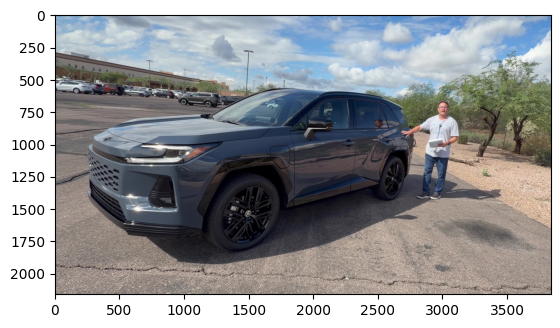

In [ ]:
query_num = 10
seconds = match_range(smoothed_binary_data, query_ds[query_num]["image"], model)
clips = get_clips(seconds, gap_threshold=8)
clips = filter_noise(clips)
frame_clips = []
for i in clips:
    frame_clips.append((get_img_from_stamp(i[0]), get_img_from_stamp(i[1])))


print(clips)
print(frame_clips)

plt.imshow(query_ds[query_num]["image"])



In [ ]:
for i in range(len(query_ds)):
    query = query_ds[i]
    seconds = match_range(smoothed_binary_data, query_ds[i]["image"], model)
    clips = get_clips(seconds, gap_threshold=8)
    if len(clips) > 0:
        highest_clip = get_largest_clip(clips)
        print(i, highest_clip)
    else:
        print(i, "Couldn't find")




0: 384x640 1 back_left_light, 1 front_glass, 1 front_left_door, 1 left_mirror, 2 wheels, 71.3ms
Speed: 2.6ms preprocess, 71.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Query looks for: {'back_left_light', 'front_glass', 'front_left_door', 'left_mirror', 'wheel'}
0 (1198.0, 1284.0)

0: 384x640 1 back_left_door, 1 front_left_door, 1 left_mirror, 1 wheel, 58.3ms
Speed: 1.9ms preprocess, 58.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Query looks for: {'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
1 (1224.0, 1250.0)

0: 384x640 1 back_left_door, 1 back_left_light, 1 front_left_door, 1 left_mirror, 1 wheel, 56.7ms
Speed: 1.7ms preprocess, 56.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Query looks for: {'back_left_light', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
2 (1328.0, 1368.0)

0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 hood, 1 left_mirror, 1

In [ ]:
# Storage for our final Parquet rows
retrieval_results = []

for i in range(len(query_ds)):
    # Get the query image and its detected parts
    query_img = query_ds[i]["image"]
    query_res = model.predict(query_img, conf=0.5, verbose=False)
    
    # Get the specific labels used for this retrieval
    query_bundle = set([query_res[0].names[int(b.cls[0])] for b in query_res[0].boxes])
    
    if not query_bundle:
        print(f"Index {i}: No parts detected in query image. Skipping.")
        continue

    seconds = match_range(smoothed_binary_data, query_img, model)
    clips = get_clips(seconds, gap_threshold=8)

    if clips:
        highest_clip = get_largest_clip(clips)
        start_ts, end_ts = highest_clip
        
        # Round about way for estimating num_detections
        supporting_mask = (
            raw_data['timestamp_sec'].between(start_ts, end_ts) & 
            raw_data['class_label'].isin(query_bundle)
        )
        num_detections = len(raw_data[supporting_mask])

        retrieval_results.append({
            "start_timestamp": start_ts,
            "end_timestamp": end_ts,
            "class_labels_used": ", ".join(sorted(query_bundle)),
            "number_of_supporting_detections": num_detections,
            "query_index": i
        })
        
        print(f"Index {i}: Found {highest_clip} with {num_detections} supports.")
    else:
        print(f"Index {i}: Couldn't find any clips.")

# save to Parquet
retrieval_df = pd.DataFrame(retrieval_results)
retrieval_df.to_parquet('retrieval_summary.parquet', index=False)

Query looks for: {'back_left_light', 'front_glass', 'front_left_door', 'left_mirror', 'wheel'}
Index 0: Found (1198.0, 1284.0) with 227 supports.
Query looks for: {'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 1: Found (1224.0, 1250.0) with 72 supports.
Query looks for: {'back_left_light', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 2: Found (1328.0, 1368.0) with 88 supports.
Query looks for: {'front_glass', 'front_bumper', 'hood', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 3: Found (1119.0, 1290.0) with 648 supports.
Query looks for: {'hood', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 4: Found (1198.0, 1278.0) with 226 supports.
Query looks for: {'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 5: Found (1224.0, 1250.0) with 72 supports.
Query looks for: {'tailgate', 'back_bumper', 'front_left_door', 'left_mirror', 'back_left_door', 'wheel'}
Index 6: Found (1224.0, 1288.0) wit